In [49]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
from typing import Dict, Text
import matplotlib.pyplot as plt

In [50]:
ratings = tfds.load("movielens/1m-ratings", split="train")
movies = tfds.load("movielens/1m-movies", split="train")



In [51]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
ratings

movies = movies.map(lambda x: x["movie_title"])

In [52]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [53]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie = np.unique(np.concatenate(list(movie_titles)))
unique_ids = np.unique(np.concatenate(list(user_ids)))
unique_movie[:10]

array([b'$1,000,000 Duck (1971)', b"'Night Mother (1986)",
       b"'Til There Was You (1997)", b"'burbs, The (1989)",
       b'...And Justice for All (1979)', b'1-900 (1994)',
       b'10 Things I Hate About You (1999)', b'101 Dalmatians (1961)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)'], dtype=object)

In [54]:
model1 = tf.keras.Sequential([
  tf.keras.layers.StringLookup(vocabulary=unique_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_ids) + 1, 32),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128)
])



In [55]:
model2 = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_movie, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie) + 1, 32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128)
])

In [56]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(model2),
  ks = (200, 400, 600, 800, 1000)
)


In [57]:
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [58]:
class MovielensModel(tfrs.Model):

  def __init__(self, model1, model2):
    super().__init__()
    self.model2: tf.keras.Model = model2
    self.model1: tf.keras.Model = model1
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.model1(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.model2(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

In [59]:
class NoBaseClassMovielensModel(tf.keras.Model):

  def __init__(self, model1, model2):
    super().__init__()
    self.model2: tf.keras.Model = model2
    self.model1: tf.keras.Model = model1
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    with tf.GradientTape() as tape:

      # Loss computation.
      user_embeddings = self.model1(features["user_id"])
      positive_movie_embeddings = self.model2(features["movie_title"])
      loss = self.task(user_embeddings, positive_movie_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    user_embeddings = self.model1(features["user_id"])
    positive_movie_embeddings = self.model2(features["movie_title"])
    loss = self.task(user_embeddings, positive_movie_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

In [60]:
model_1 = MovielensModel(model1, model2)
model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [61]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [62]:
num_epochs = 100
history = model_1.fit(cached_train,
    epochs=num_epochs)

Epoch 1/100
10/10 [==============================] - 26s 2s/step - factorized_top_k/top_200_categorical_accuracy: 0.0653 - factorized_top_k/top_400_categorical_accuracy: 0.1351 - factorized_top_k/top_600_categorical_accuracy: 0.2016 - factorized_top_k/top_800_categorical_accuracy: 0.2586 - factorized_top_k/top_1000_categorical_accuracy: 0.3092 - loss: 70854.0753 - regularization_loss: 0.0000e+00 - total_loss: 70854.0753
Epoch 2/100
10/10 [==============================] - 24s 2s/step - factorized_top_k/top_200_categorical_accuracy: 0.1250 - factorized_top_k/top_400_categorical_accuracy: 0.2252 - factorized_top_k/top_600_categorical_accuracy: 0.3104 - factorized_top_k/top_800_categorical_accuracy: 0.3830 - factorized_top_k/top_1000_categorical_accuracy: 0.4448 - loss: 70180.9219 - regularization_loss: 0.0000e+00 - total_loss: 70180.9219
Epoch 3/100
10/10 [==============================] - 25s 3s/step - factorized_top_k/top_200_categorical_accuracy: 0.1812 - factorized_top_k/top_400_cate

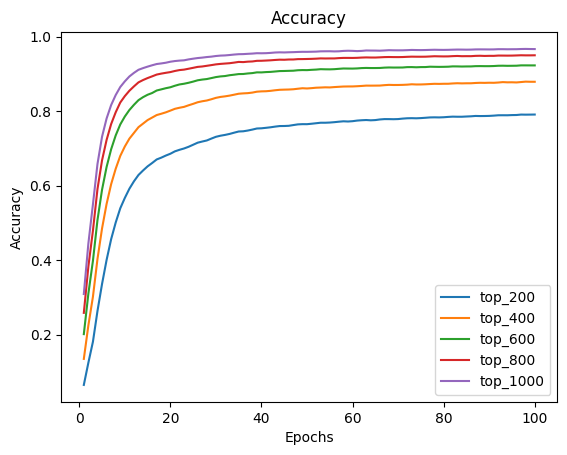

In [63]:
num_validation_runs = len(history.history["factorized_top_k/top_200_categorical_accuracy"])
epochs = [(x + 1) for x in range(num_validation_runs)]

plt.plot(epochs, history.history["factorized_top_k/top_200_categorical_accuracy"], label="top_200")
plt.plot(epochs, history.history["factorized_top_k/top_400_categorical_accuracy"], label="top_400")
plt.plot(epochs, history.history["factorized_top_k/top_600_categorical_accuracy"], label="top_600")
plt.plot(epochs, history.history["factorized_top_k/top_800_categorical_accuracy"], label="top_800")
plt.plot(epochs, history.history["factorized_top_k/top_1000_categorical_accuracy"], label="top_1000")

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");
plt.legend()


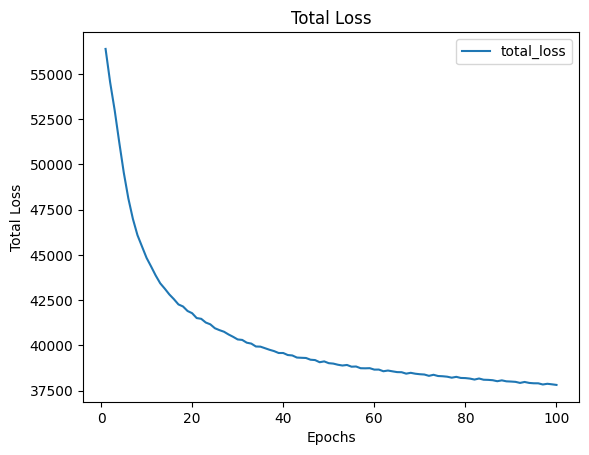

In [64]:
plt.plot(epochs, history.history["total_loss"], label="total_loss")

plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Total Loss");
plt.legend()


In [65]:
ratings = tfds.load("movielens/1m-ratings", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

In [66]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [67]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [68]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [69]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [70]:
class MovielensRate(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [71]:
model_2 = MovielensRate()
model_2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [72]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [73]:
history2 = model_2.fit(cached_train, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 2s 22ms/step - root_mean_squared_error: 2.1164 - loss: 4.1443 - regularization_loss: 0.0000e+00 - total_loss: 4.1443
Epoch 2/1000
10/10 [==============================] - 0s 9ms/step - root_mean_squared_error: 1.1578 - loss: 1.3350 - regularization_loss: 0.0000e+00 - total_loss: 1.3350
Epoch 3/1000
10/10 [==============================] - 0s 9ms/step - root_mean_squared_error: 1.1158 - loss: 1.2474 - regularization_loss: 0.0000e+00 - total_loss: 1.2474
Epoch 4/1000
10/10 [==============================] - 0s 9ms/step - root_mean_squared_error: 1.1104 - loss: 1.2360 - regularization_loss: 0.0000e+00 - total_loss: 1.2360
Epoch 5/1000
10/10 [==============================] - 0s 8ms/step - root_mean_squared_error: 1.1073 - loss: 1.2290 - regularization_loss: 0.0000e+00 - total_loss: 1.2290
Epoch 6/1000
10/10 [==============================] - 0s 9ms/step - root_mean_squared_error: 1.1030 - loss: 1.2196 - regularization_loss: 0.0000e+00 

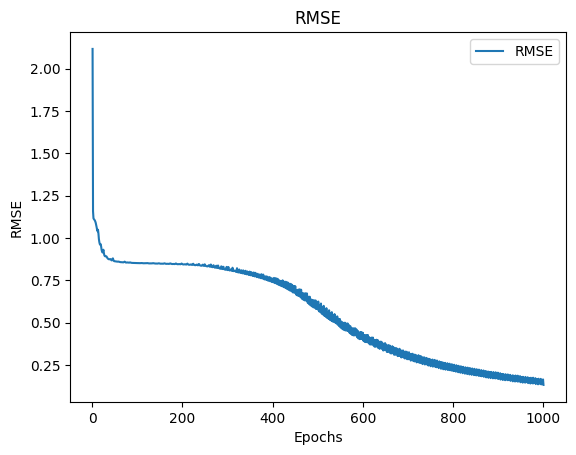

In [74]:
num_validation_runs2 = len(history2.history["root_mean_squared_error"])
epochs2 = [(x + 1) for x in range(num_validation_runs2)]

plt.plot(epochs2, history2.history["root_mean_squared_error"], label="RMSE")

plt.title("RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE");
plt.legend()


In [75]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [76]:
index = tfrs.layers.factorized_top_k.BruteForce(model_1.model1)

index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model_1.model2)))
)
id = 200
_, titles = index(tf.constant([f'{id}']))
print(f"Recommendations for user {id} : {titles[0, :100]}\n")
list_title = list(titles.numpy().astype('str'))
res = [list(item) for item in list_title]
flat_l = flatten_list(res)
test_ratings = {}
test_movie_titles = flat_l
for movie_title in test_movie_titles:
  test_ratings[movie_title] = model_2({
      "user_id": np.array([f"{id}"]),
      "movie_title": np.array([movie_title])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Recommendations for user 200 : [b'Entrapment (1999)' b'Arachnophobia (1990)'
 b'Austin Powers: The Spy Who Shagged Me (1999)'
 b'What Planet Are You From? (2000)' b"She's All That (1999)"
 b'10 Things I Hate About You (1999)' b'Big Daddy (1999)'
 b'Back to the Future Part III (1990)' b'Payback (1999)'
 b'Out-of-Towners, The (1999)']

Ratings:
Arachnophobia (1990): [[3.9649105]]
Payback (1999): [[3.7346587]]
Back to the Future Part III (1990): [[3.051338]]
She's All That (1999): [[2.947366]]
Austin Powers: The Spy Who Shagged Me (1999): [[2.8757668]]
Out-of-Towners, The (1999): [[2.5154676]]
What Planet Are You From? (2000): [[2.3418906]]
10 Things I Hate About You (1999): [[1.9289513]]
Entrapment (1999): [[1.9132469]]
Big Daddy (1999): [[1.3656704]]
